# not recognizing selective cells fo 52, 64, and 991 for SS session. Need to look into why. Excluding these animals for now

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')

# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'selectivity_vHPCAnimals'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'extract_pos_neg', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'plot_it', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
all_animals = 'c10m6','c3m3', '90', '91', '93', '93b', '64', '991', '52', #, 'NEW_57_1day',
#'NEW_58', 'NEW_991b', 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7',

day1_animals = 'c10m6','c3m3', '90', '91', '93', '93b', '64', '991', '52', #, 'NEW_57_1day',
#'NEW_58', 'NEW_991b', 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7',
day2_animals = 'c10m6','c3m3', '90', '91', '93', '93b', '64', '991', '52', #, 'NEW_57_1day',
#'NEW_58', 'NEW_991b', 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7',

#vHPC_animals = 'c10m6', '90', '91', '93', '93b', 'c3m3', '52', '64', '991',# 'NEW_57_1day',
#'NEW_58', 'NEW_991b'
#dHPC_animals = 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7,'

In [8]:
#first load without blasts (because not animals have blast trials, and won't be able to load ANY data from those animals because
#the whole loading iteration will fail for that animal)
sessions = 'day1','day2'
stimuli = 'sucroseAndShock',#,'blasts' we don't need to explicitly fetch blasts becuase they're already in the SS and odor selectivity nbs

In [9]:
for sess in sessions:
    exec('selectivity_%s = {}'%sess)
    for ani in eval('%s_animals'%sess):
        for stim in stimuli:
            try:
                eval('selectivity_%s'%sess).update({ani: ut.load_variable('selectivity', '../%s/%s/%s/notebooks/autorestore/selectivity/'%(ani, sess, stim))})
            except IOError:
                print("Skip", ani, sess, stim)
                continue

# SS trials

In [10]:
stims = ['consumption_25_4s_us', 'shock_10_4s_us', 'consumption_25_pre', 'shock_10_pre']

In [11]:
def extract_pos_neg(selectivity, mice, significance=0.05,
                    odors=None):
    
    if odors is None:
        odors = stims

    posmods = {}
    negmods = {}

    for mouse in mice:
        try:
            posmods[mouse] = []
            negmods[mouse] = []
            sel = selectivity[mouse]
    #         print sel
            n_cells = len(selectivity[mouse])
            for od in odors:
                dirs = [s[1] for s in sel[od]]
                pvals = [s[0][1] for s in sel[od]]
                posmods[mouse].append(np.mean([d>0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))]))
                negmods[mouse].append(np.mean([d<0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))])) 
        except KeyError:
            print "No data for %s (%s)." % (mouse, odors)
            posmods[mouse] = [np.nan]*len(odors)
            negmods[mouse] = [np.nan]*len(odors)
    return posmods, negmods

In [12]:
pos_day1, neg_day1 = extract_pos_neg(selectivity_day1, day1_animals)
pos_day2, neg_day2 = extract_pos_neg(selectivity_day2, day2_animals)

In [13]:
pos_day1['991']

[0.13592233009708737,
 0.32038834951456313,
 0.048543689320388349,
 0.029126213592233011]

In [14]:
def plot_it(animals, pos_all, neg_all, with_dots=False, which_odors=None, figsize=(4, 2)):
    
    fig, ax = pl.subplots(1, 1, figsize=figsize)

    if which_odors is None:
        which_odors = range(len(stims))
    
    pos = {k:v for k, v in pos_all.iteritems() if k in animals}
    neg = {k:v for k, v in neg_all.iteritems() if k in animals}

    for i, w in enumerate(which_odors):
        vals = np.r_[pos.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]-0.05, vals, 'o', ms=3, color='k', mew=0, alpha=0.3)
        ax.plot([i-0.2-0.05, i+0.2-0.05], [vals.mean()]*2, color='k', alpha=1)
        ax.errorbar(i-0.05, vals.mean(), sstats.sem(vals), lw=1, color='k')
        vals = -np.r_[neg.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]+0.05, vals, 'o', ms=3, color='C0', mew=0, alpha=0.3)
        ax.plot([i-0.2+0.05, i+0.2+0.05], [vals.mean()]*2, color='C0', alpha=1)
        ax.errorbar(i+0.05, vals.mean(), sstats.sem(vals), lw=1, color='C0')

    ax.set_xticks(range(len(which_odors)))
    ax.set_xticklabels(stims, fontsize=5, rotation=70)

    #     ax.set_xlabel('Odor')
    pt.nicer_plot(ax)
    # ax.set_ylim(-.1, .5)
    ax.hlines(0, -.5, len(which_odors), color='0.8', linestyles='dotted', lw=1)

    ax.set_ylabel('Percentage of\nResponding Neurons', fontsize=5)

    ax.set_ylim(-18, 80)

    # pl.savefig('../img/selectivity_prepost.pdf')
    return fig, ax
    

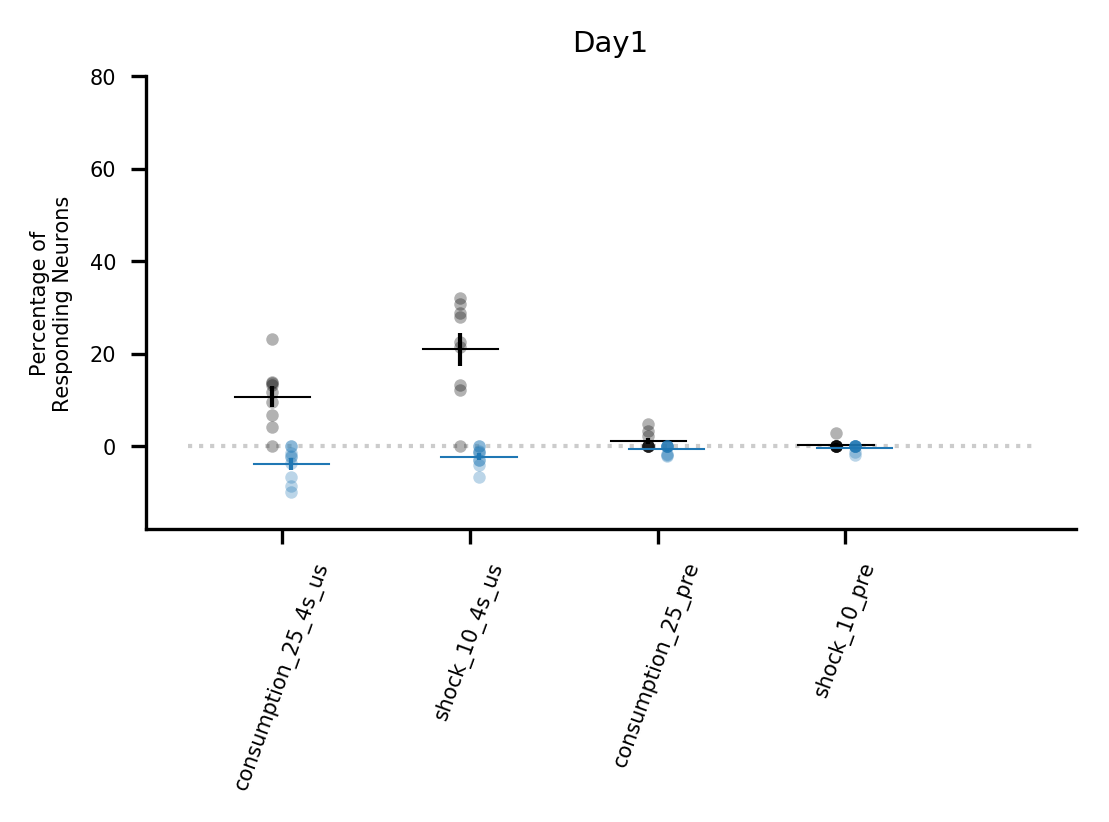

In [15]:
fig, ax = plot_it(day1_animals, pos_day1, neg_day1, with_dots=True)
ax.set_title('Day1', fontsize=7)
#fig.savefig('../img/selectivity_day1.pdf', bbok='tight')

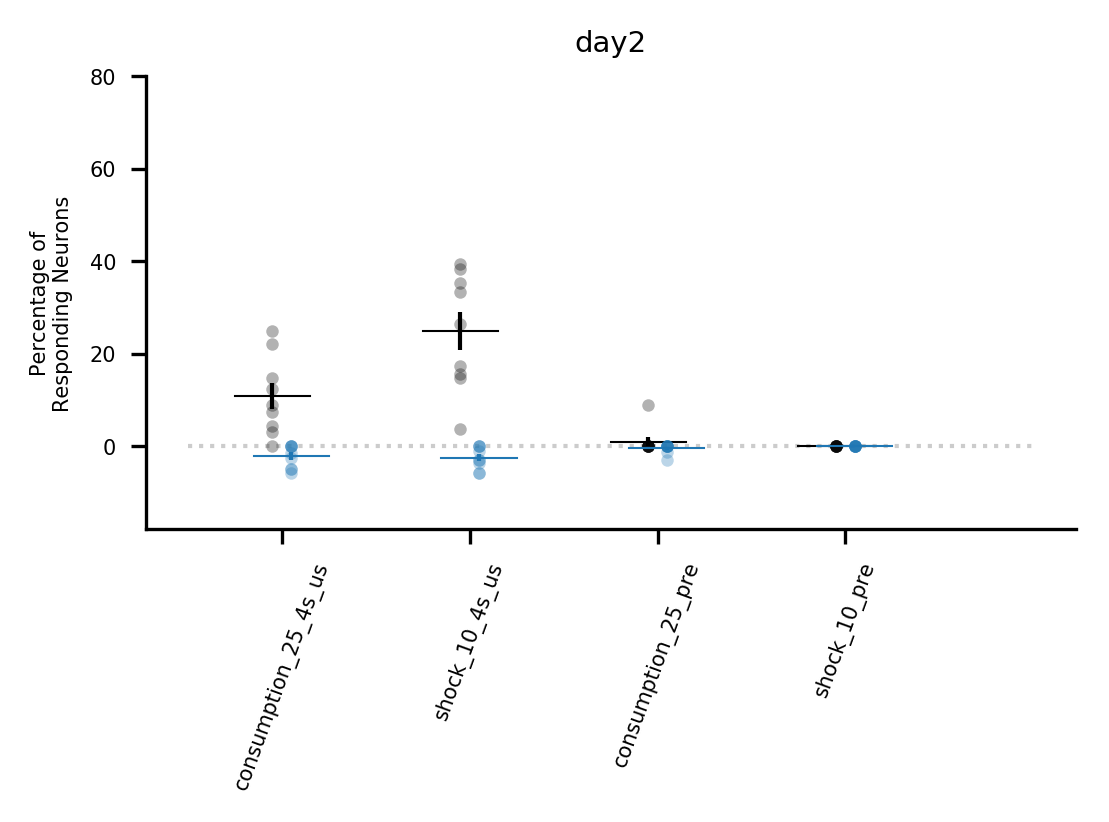

In [16]:
fig, ax = plot_it(day2_animals, pos_day2, neg_day2, with_dots=True)
ax.set_title('day2', fontsize=7)
fig.savefig('../img/selectivity_day2.pdf', bbok='tight')

In [17]:
pvalue = 0.05
for sess in sessions:
    
    exec("pvs_%s = {}"%sess)
    exec("pvs_%s['sucrose'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['consumption_25_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))
    exec("pvs_%s['shock'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['shock_10_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))

# plots below have no multiple comparisons adjustment

day1 sucrose 215
day2 sucrose 185
day1 shock 251
day2 shock 249
day1 n 700
day2 n 666


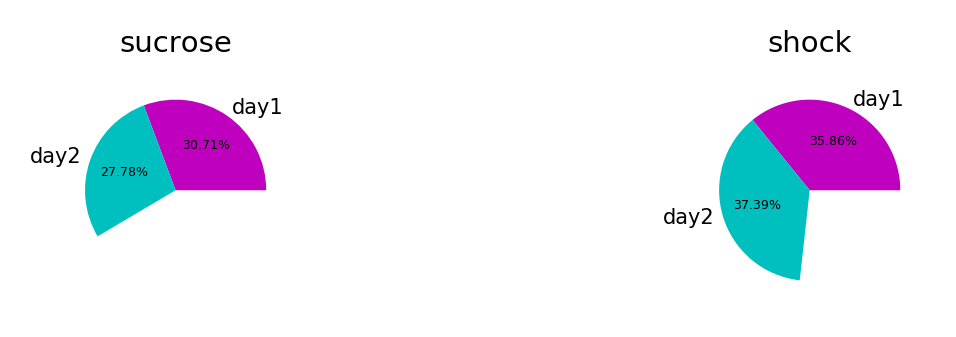

In [18]:
pvalue = 0.05
i=0
conditions = ['sucrose','shock']
fig, axs = pl.subplots(1, 2, figsize=(5, 1))

for cond, ax in zip(conditions, axs):
    i=i+1
    p = ax.pie([1.*eval("pvs_day1")[cond].sum()/len(eval("pvs_day1")[cond]),
           1.*eval("pvs_day2")[cond].sum()/len(eval("pvs_day2")[cond])],
           colors=['m', 'c', '0.7'], labels=['day1', 'day2'], autopct=lambda x: "%.2f%%"%(x))
    print 'day1 %s'%cond,
    print eval("pvs_day1")[cond].sum()
    print 'day2 %s'%cond,
    print eval("pvs_day2")[cond].sum()

    ax.set_title(cond)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
    
    ax.set_aspect('equal')

print 'day1 n',
print len(eval("pvs_day1")[cond])
print 'day2 n',
print len(eval("pvs_day2")[cond])


#fig.savefig('../img/%s__pies.pdf'%NOTEBOOK_NAME, bbox='tight')

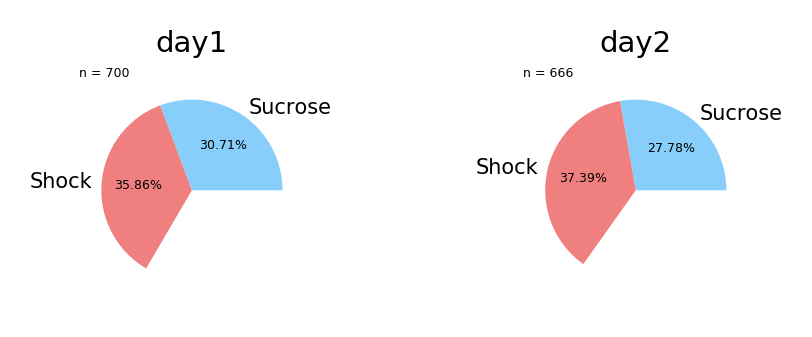

In [19]:
#of all selective cells, what proportion were selective for each stimulus?
pvalue = 0.05
fig, axs = pl.subplots(1, 2, figsize=(3.5, 1))

for sess, ax in zip(sessions, axs):
    
    p = ax.pie([1.*eval("pvs_%s"%sess)['sucrose'].sum()/len(eval("pvs_%s"%sess)['sucrose']),
           1.*eval("pvs_%s"%sess)['shock'].sum()/len(eval("pvs_%s"%sess)['shock'])],
           colors=['lightskyblue', 'lightcoral'], labels=['Sucrose', 'Shock'], autopct=lambda x: "%.2f%%"%(x))

    ax.set_title(sess)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['sucrose'])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


#fig.savefig('../img/%s__pies.pdf'%NOTEBOOK_NAME, bbox='tight')

# Now for odors

In [20]:
#first load without blasts (because not animals have blast trials, and won't be able to load ANY data from those animals because
#the whole loading iteration will fail for that animal)
sessions = 'day1','day2'
stimuli = 'odors', #,'blasts' we don't need to explicitly fetch blasts becuase they're already in the SS and odor selectivity nbs

In [21]:
for sess in sessions:
    exec('selectivity_%s = {}'%sess)
    for ani in eval('%s_animals'%sess):
        for stim in stimuli:
            try:
                eval('selectivity_%s'%sess).update({ani: ut.load_variable('selectivity', '../%s/%s/%s/notebooks/autorestore/selectivity/'%(ani, sess, stim))})
            except IOError:
                print("Skip", ani, sess, stim)
                continue

In [23]:
selectivity_day1['64'].keys()

['female_pre',
 'coyote_us',
 'shock_10_us',
 'shock_10_4s_us',
 'consumption_25_4s_us',
 'female_4s_us',
 'coyote_4s_us',
 'female_us',
 'consumption_25_pre',
 'shock_10_pre',
 'coyote_pre',
 'consumption_25_us']

# Odor trials

In [24]:
stims = ['coyote_4s_us', 'female_4s_us', 'coyote_pre', 'female_pre']

In [25]:
def extract_pos_neg(selectivity, mice, significance=0.05,
                    odors=None):
    
    if odors is None:
        odors = stims

    posmods = {}
    negmods = {}

    for mouse in mice:
        try:
            posmods[mouse] = []
            negmods[mouse] = []
            sel = selectivity[mouse]
    #         print sel
            n_cells = len(selectivity[mouse])
            for od in odors:
                dirs = [s[1] for s in sel[od]]
                pvals = [s[0][1] for s in sel[od]]
                posmods[mouse].append(np.mean([d>0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))]))
                negmods[mouse].append(np.mean([d<0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))])) 
        except KeyError:
            print "No data for %s (%s)." % (mouse, odors)
            posmods[mouse] = [np.nan]*len(odors)
            negmods[mouse] = [np.nan]*len(odors)
    return posmods, negmods

In [26]:
pos_day1, neg_day1 = extract_pos_neg(selectivity_day1, day1_animals)
pos_day2, neg_day2 = extract_pos_neg(selectivity_day2, day2_animals)

In [28]:
pos_day1['64']

[0.0, 0.054054054054054057, 0.0, 0.0]

In [29]:
def plot_it(animals, pos_all, neg_all, with_dots=False, which_odors=None, figsize=(4, 2)):
    
    fig, ax = pl.subplots(1, 1, figsize=figsize)

    if which_odors is None:
        which_odors = range(len(stims))
    
    pos = {k:v for k, v in pos_all.iteritems() if k in animals}
    neg = {k:v for k, v in neg_all.iteritems() if k in animals}

    for i, w in enumerate(which_odors):
        vals = np.r_[pos.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]-0.05, vals, 'o', ms=3, color='k', mew=0, alpha=0.3)
        ax.plot([i-0.2-0.05, i+0.2-0.05], [vals.mean()]*2, color='k', alpha=1)
        ax.errorbar(i-0.05, vals.mean(), sstats.sem(vals), lw=1, color='k')
        vals = -np.r_[neg.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]+0.05, vals, 'o', ms=3, color='C0', mew=0, alpha=0.3)
        ax.plot([i-0.2+0.05, i+0.2+0.05], [vals.mean()]*2, color='C0', alpha=1)
        ax.errorbar(i+0.05, vals.mean(), sstats.sem(vals), lw=1, color='C0')

    ax.set_xticks(range(len(which_odors)))
    ax.set_xticklabels(stims, fontsize=5, rotation=70)

    #     ax.set_xlabel('Odor')
    pt.nicer_plot(ax)
    # ax.set_ylim(-.1, .5)
    ax.hlines(0, -.5, len(which_odors), color='0.8', linestyles='dotted', lw=1)

    ax.set_ylabel('Percentage of\nResponding Neurons', fontsize=5)

    ax.set_ylim(-18, 80)

    # pl.savefig('../img/selectivity_prepost.pdf')
    return fig, ax
    

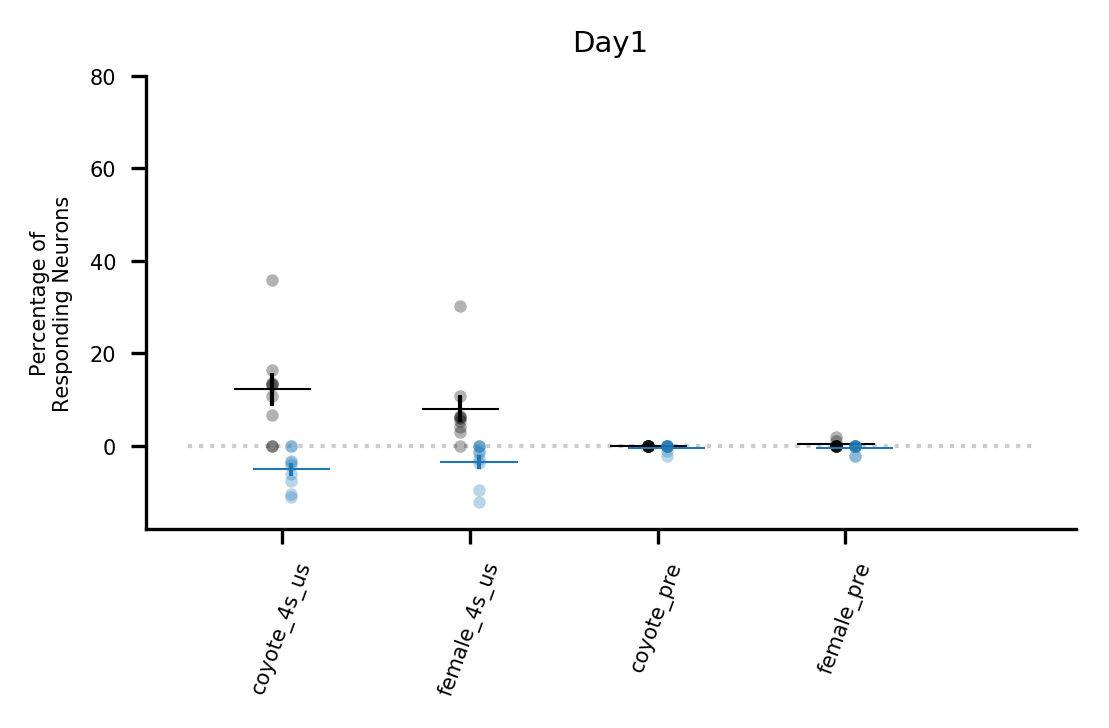

In [30]:
fig, ax = plot_it(day1_animals, pos_day1, neg_day1, with_dots=True)
ax.set_title('Day1', fontsize=7)
#fig.savefig('../img/selectivity_day1.pdf', bbok='tight')

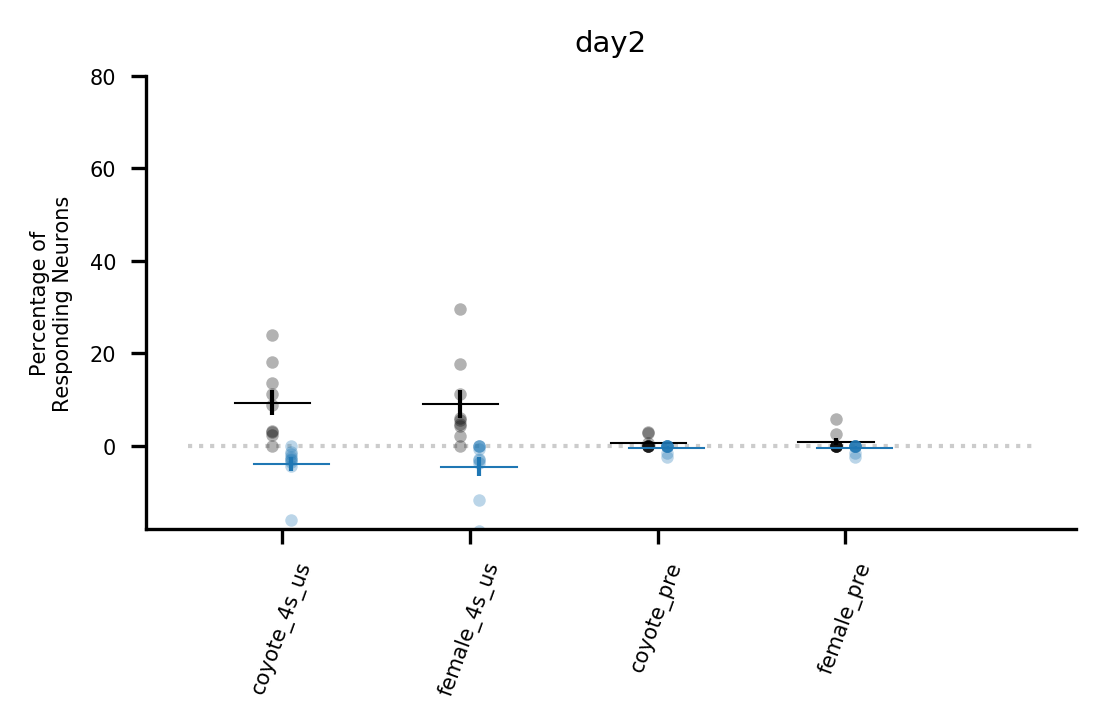

In [31]:
fig, ax = plot_it(day2_animals, pos_day2, neg_day2, with_dots=True)
ax.set_title('day2', fontsize=7)
fig.savefig('../img/selectivity_day2.pdf', bbok='tight')

In [32]:
pvalue = 0.05
for sess in sessions:
    
    exec("pvs_%s = {}"%sess)
    exec("pvs_%s['coyote'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['coyote_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))
    exec("pvs_%s['female'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['female_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))
    #exec("pvs_%s['blast'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['blast_4s_us']]\
    #                                 for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))

# plots below have no multiple comparisons adjustment

day1 coyote 188
day2 coyote 174
day1 female 171
day2 female 176
day1 n 663
day2 n 651


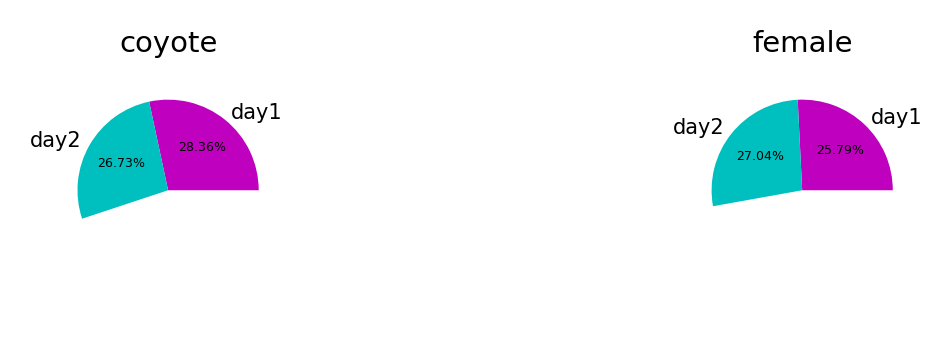

In [33]:
pvalue = 0.05
i=0
conditions = ['coyote','female']#,'blast']
fig, axs = pl.subplots(1, 2, figsize=(5, 1))

for cond, ax in zip(conditions, axs):
    i=i+1
    p = ax.pie([1.*eval("pvs_day1")[cond].sum()/len(eval("pvs_day1")[cond]),
           1.*eval("pvs_day2")[cond].sum()/len(eval("pvs_day2")[cond])],
           colors=['m', 'c', '0.7'], labels=['day1', 'day2'], autopct=lambda x: "%.2f%%"%(x))
    print 'day1 %s'%cond,
    print eval("pvs_day1")[cond].sum()
    print 'day2 %s'%cond,
    print eval("pvs_day2")[cond].sum()

    ax.set_title(cond)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
    
    ax.set_aspect('equal')

print 'day1 n',
print len(eval("pvs_day1")[cond])
print 'day2 n',
print len(eval("pvs_day2")[cond])


#fig.savefig('../img/%s__pies.pdf'%NOTEBOOK_NAME, bbox='tight')

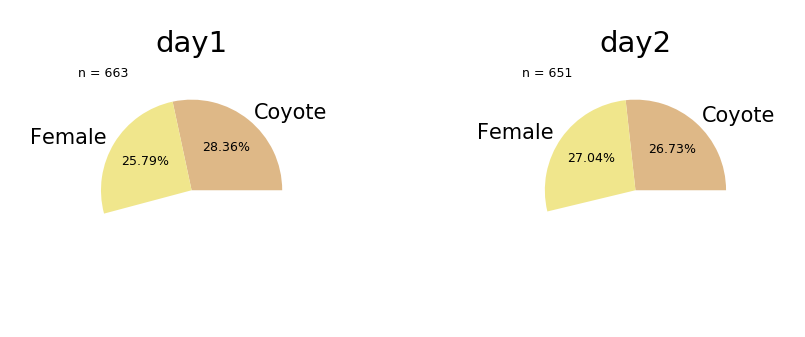

In [34]:
#of all selective cells, what proportion were selective for each stimulus?
pvalue = 0.05
fig, axs = pl.subplots(1, 2, figsize=(3.5, 1))

for sess, ax in zip(sessions, axs):
    
    p = ax.pie([1.*eval("pvs_%s"%sess)['coyote'].sum()/len(eval("pvs_%s"%sess)['coyote']),
           1.*eval("pvs_%s"%sess)['female'].sum()/len(eval("pvs_%s"%sess)['female'])],
           #1.*eval("pvs_%s"%sess)['blast'].sum()/len(eval("pvs_%s"%sess)['blast'])],
           colors=['burlywood','khaki'], labels=['Coyote', 'Female'], autopct=lambda x: "%.2f%%"%(x))

    ax.set_title(sess)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['coyote'])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


#fig.savefig('../img/%s__pies.pdf'%NOTEBOOK_NAME, bbox='tight')

# with all stimuli below, but excluding older animals until I can figure out how to not overwrite selectivity data when importing data from a different session (ie overwriting SS when importing odor selectivity data using .update in cell9

In [35]:
all_animals = 'c10m6','c3m3', '90', '91', '93', '93b'#, '64', '991', '52', #, 'NEW_57_1day',
#'NEW_58', 'NEW_991b', 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7',

day1_animals = 'c10m6','c3m3', '90', '91', '93', '93b'#, '64', '991', '52', #, 'NEW_57_1day',
#'NEW_58', 'NEW_991b', 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7',
day2_animals = 'c10m6','c3m3', '90', '91', '93', '93b'#, '64', '991', '52', #, 'NEW_57_1day',
#'NEW_58', 'NEW_991b', 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7',

#vHPC_animals = 'c10m6', '90', '91', '93', '93b', 'c3m3', '52', '64', '991',# 'NEW_57_1day',
#'NEW_58', 'NEW_991b'
#dHPC_animals = 'NEW_dHPC6_1day', 'NEW_dHPC7b_1day', 'dHPC20', 'dHPC4', 'dHPC7,'

In [36]:
stims = ['consumption_25_4s_us', 'shock_10_4s_us', 'coyote_4s_us', 'female_4s_us', 'blast_4s_us',
        'consumption_25_pre', 'shock_10_pre',  'coyote_pre', 'female_pre', 'blast_pre',]

In [37]:
def extract_pos_neg(selectivity, mice, significance=0.05,
                    odors=None):
    
    if odors is None:
        odors = stims

    posmods = {}
    negmods = {}

    for mouse in mice:
        try:
            posmods[mouse] = []
            negmods[mouse] = []
            sel = selectivity[mouse]
    #         print sel
            n_cells = len(selectivity[mouse])
            for od in odors:
                dirs = [s[1] for s in sel[od]]
                pvals = [s[0][1] for s in sel[od]]
                posmods[mouse].append(np.mean([d>0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))]))
                negmods[mouse].append(np.mean([d<0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))])) 
        except KeyError:
            print "No data for %s (%s)." % (mouse, odors)
            posmods[mouse] = [np.nan]*len(odors)
            negmods[mouse] = [np.nan]*len(odors)
    return posmods, negmods

In [38]:
pos_day1, neg_day1 = extract_pos_neg(selectivity_day1, day1_animals)
pos_day2, neg_day2 = extract_pos_neg(selectivity_day2, day2_animals)

In [39]:
def plot_it(animals, pos_all, neg_all, with_dots=False, which_odors=None, figsize=(4, 2)):
    
    fig, ax = pl.subplots(1, 1, figsize=figsize)

    if which_odors is None:
        which_odors = range(len(stims))
    
    pos = {k:v for k, v in pos_all.iteritems() if k in animals}
    neg = {k:v for k, v in neg_all.iteritems() if k in animals}

    for i, w in enumerate(which_odors):
        vals = np.r_[pos.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]-0.05, vals, 'o', ms=3, color='k', mew=0, alpha=0.3)
        ax.plot([i-0.2-0.05, i+0.2-0.05], [vals.mean()]*2, color='k', alpha=1)
        ax.errorbar(i-0.05, vals.mean(), sstats.sem(vals), lw=1, color='k')
        vals = -np.r_[neg.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]+0.05, vals, 'o', ms=3, color='C0', mew=0, alpha=0.3)
        ax.plot([i-0.2+0.05, i+0.2+0.05], [vals.mean()]*2, color='C0', alpha=1)
        ax.errorbar(i+0.05, vals.mean(), sstats.sem(vals), lw=1, color='C0')

    ax.set_xticks(range(len(which_odors)))
    ax.set_xticklabels(stims, fontsize=5, rotation=70)

    #     ax.set_xlabel('Odor')
    pt.nicer_plot(ax)
    # ax.set_ylim(-.1, .5)
    ax.hlines(0, -.5, len(which_odors), color='0.8', linestyles='dotted', lw=1)

    ax.set_ylabel('Percentage of\nResponding Neurons', fontsize=5)

    ax.set_ylim(-18, 80)

    # pl.savefig('../img/selectivity_prepost.pdf')
    return fig, ax
    

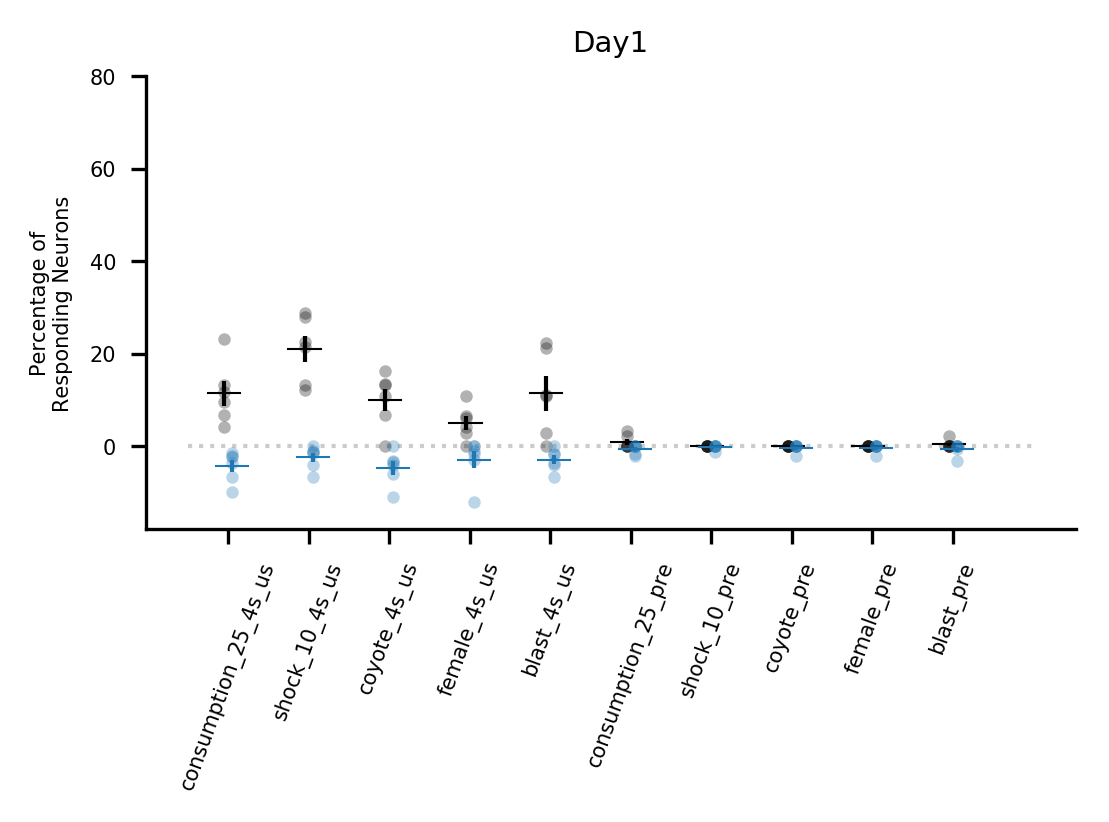

In [40]:
fig, ax = plot_it(day1_animals, pos_day1, neg_day1, with_dots=True)
ax.set_title('Day1', fontsize=7)
#fig.savefig('../img/selectivity_day1.pdf', bbok='tight')

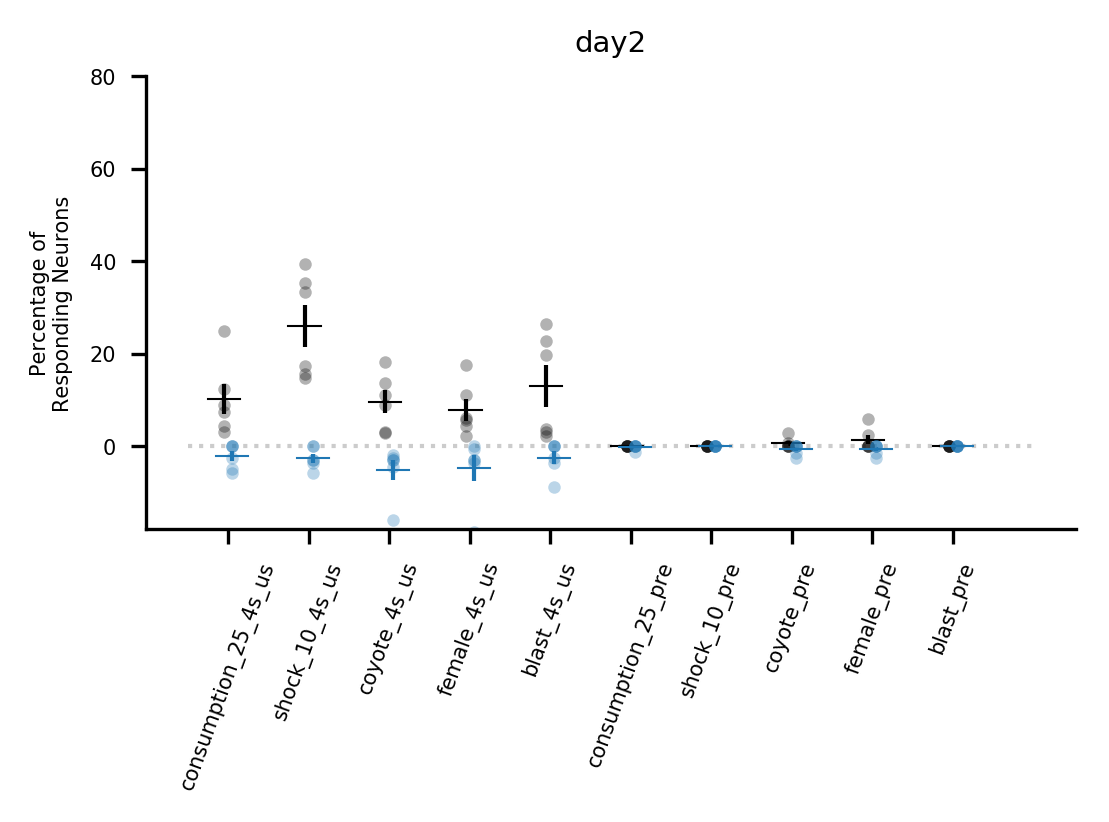

In [41]:
fig, ax = plot_it(day2_animals, pos_day2, neg_day2, with_dots=True)
ax.set_title('day2', fontsize=7)
fig.savefig('../img/selectivity_day2.pdf', bbok='tight')

In [42]:
pvalue = 0.05
for sess in sessions:
    
    exec("pvs_%s = {}"%sess)
    exec("pvs_%s['sucrose'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['consumption_25_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))
    exec("pvs_%s['shock'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['shock_10_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))
    exec("pvs_%s['coyote'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['coyote_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))
    exec("pvs_%s['female'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['female_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))
    exec("pvs_%s['blast'] = np.concatenate([[s[0][-1]<pvalue for s in selectivity_%s[ani]['blast_4s_us']]\
                                     for ani in all_animals if ani in selectivity_%s.keys()])"%(sess, sess, sess))

# plots below have no multiple comparisons adjustment

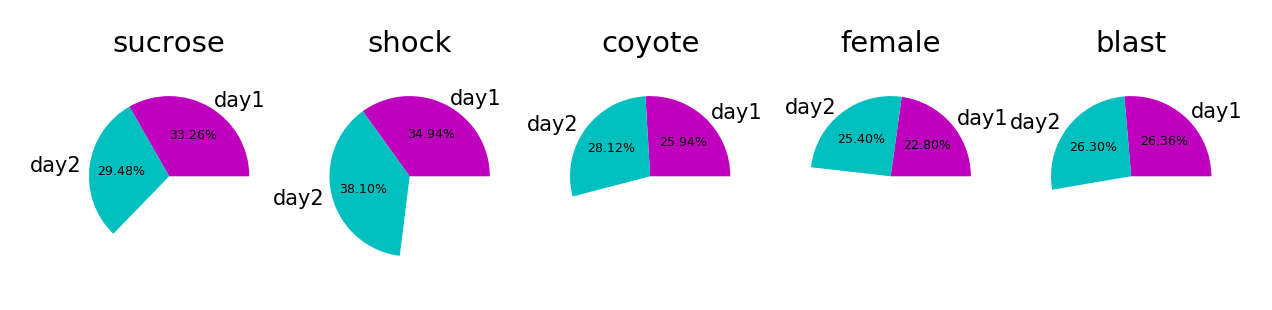

In [43]:
pvalue = 0.05
conditions = ['sucrose','shock','coyote','female','blast']
fig, axs = pl.subplots(1, 5, figsize=(5, 1))

for cond, ax in zip(conditions, axs):
    
    p = ax.pie([1.*eval("pvs_day1")[cond].sum()/len(eval("pvs_day1")[cond]),
           1.*eval("pvs_day2")[cond].sum()/len(eval("pvs_day2")[cond])],
           colors=['m', 'c', '0.7'], labels=['day1', 'day2'], autopct=lambda x: "%.2f%%"%(x))

    ax.set_title(cond)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    #ax.text(0, 1, "n = %d"%(len(eval("pvs_day1")[cond])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


#fig.savefig('../img/%s__pies.pdf'%NOTEBOOK_NAME, bbox='tight')

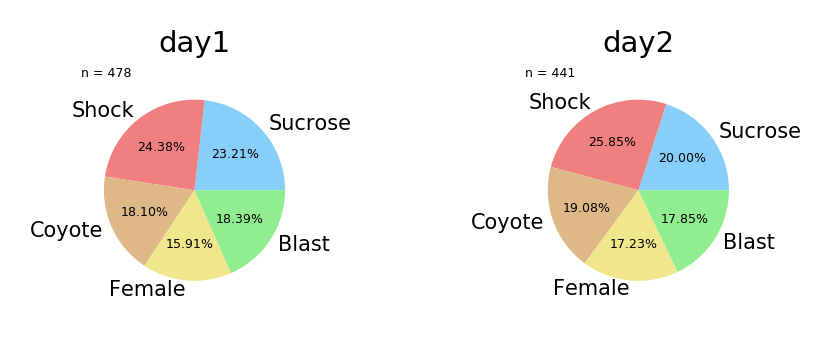

In [44]:
#of all selective cells, what proportion were selective for each stimulus?
pvalue = 0.05
fig, axs = pl.subplots(1, 2, figsize=(3.5, 1))

for sess, ax in zip(sessions, axs):
    
    p = ax.pie([1.*eval("pvs_%s"%sess)['sucrose'].sum()/len(eval("pvs_%s"%sess)['sucrose']),
           1.*eval("pvs_%s"%sess)['shock'].sum()/len(eval("pvs_%s"%sess)['shock']),
           1.*eval("pvs_%s"%sess)['coyote'].sum()/len(eval("pvs_%s"%sess)['coyote']),
           1.*eval("pvs_%s"%sess)['female'].sum()/len(eval("pvs_%s"%sess)['female']),
           1.*eval("pvs_%s"%sess)['blast'].sum()/len(eval("pvs_%s"%sess)['blast'])],
           colors=['lightskyblue', 'lightcoral', 'burlywood','khaki', 'lightgreen'], labels=['Sucrose', 'Shock','Coyote', 'Female','Blast'], autopct=lambda x: "%.2f%%"%(x))

    ax.set_title(sess)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['sucrose'])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


#fig.savefig('../img/%s__pies.pdf'%NOTEBOOK_NAME, bbox='tight')

In [45]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
